In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

In [14]:
device = 'cuda'

In [19]:
%load_ext autoreload
%autoreload 2

## define helper functions

In [72]:
# define a function to gather positions
def get_pos(n_x, n_y):
    # create the hex lattice
    xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
    # derive the y-step given a distance of one
    y_step = np.sqrt(1**2+0.5**2)
    ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
    # define the positions
    pos = np.vstack([xs.flatten(), ys.flatten()]).T
    return pos

In [73]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.ones((sphex.shape[0], n_genes)).astype('float32')).to(device)
    # compute the gex
    for idx in range(n_genes):
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
        if idx < n_genes-1:
            gex[:,idx] *= torch.cos(sphex[:,idx])
    return torch.nan_to_num(gex).to(device)

In [74]:
from torch_geometric.nn import GCNConv
from sklearn.neighbors import kneighbors_graph
# define the number of neighbors (six for visium)
n_neighbors = 6
# define the simcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # print
        # print(f"device of self.gex is {self.gex.get_device()}")
        # print(f"device of edge_index is {edge_index.get_device()}")
        edge_index = edge_index.to(device)
        # print(f"device of edge_index is {edge_index.get_device()}")
        # print(f"device of model is {self.get_device()}")
        
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [75]:
# define the celcomen class
class celcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(celcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_gex(self, gex):
        """
        Artifically sets the current sphex matrix
        """
        self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [76]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## perform simulations

In [83]:
def run_scc(input_g2g, params, plot=False):
    # define the hyperparameters
    n_x, n_y, n_genes = params[:3]
    learning_rate = params[3]
    zmft_scalar = params[4]
    seed = params[5]
    epochs = params[6]
    # instantiate the model, input and output will be the same
    model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
    # now perform the simulation
    np.random.seed(seed)
    # retrieve the positions
    pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    # artifically set the g2g matrix
    model.set_g2g(input_g2g)
    model.set_g2g_intra(input_g2g)

    # initialize a gene expression matrix
    input_sphex = np.random.normal(np.pi, np.pi/2, size=(pos.shape[0], n_genes-1)).astype('float32')
    model.set_sphex(torch.from_numpy(input_sphex.copy()))

    # move to device
    model.to(device)
    
    # set up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []
    # train the model
    model.train()
    # work through epochs
    for epoch in range(epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model(edge_index, 1)
        if epoch == 0:
            input_gex, input_msg = model.gex.clone().detach().cpu().numpy(), msg.clone().detach().cpu().numpy()
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
        losses.append(loss.detach().cpu().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # create the plot
    if plot:
        fig, ax = plt.subplots(figsize=[6, 4])
        ax.grid(False)
        ax.plot(losses, lw=2, color='#fe86a4')
        ax.set_xlim(0, epochs)
        vmin, vmax = min(min(losses), 0), max(losses)
        vstep = (vmax - vmin) * 0.01
        ax.set_ylim(vmin-vstep, vmax+vstep)
        ax.set(xlabel='epochs', ylabel='loss')
    
    # retrieve the data
    output_gex = model.gex.detach().cpu().numpy()
    output_msg = msg.detach().cpu().numpy()
    exp_g2g = input_g2g.detach().cpu().numpy()
    # plot the correlations
    if plot:
        for matrix in [input_gex, input_msg, output_gex, output_msg]:
            g = sns.clustermap(pd.DataFrame(matrix).corr(method='spearman'), cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                               figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
            g.ax_heatmap.grid(False)
            g.ax_cbar.grid(False)
            g.ax_heatmap.tick_params(labelrotation=0)
            
        # plot the expected g2g matrix
        g = sns.clustermap(exp_g2g, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)
        
    return losses, input_gex, output_gex, exp_g2g

In [84]:
def run_ccc_from_scc(output_gex, params, plot=False):
    # define the hyperparameters
    n_x, n_y, n_genes = params[:3]
    learning_rate = params[3]
    zmft_scalar = params[4]
    seed = params[5]
    epochs = params[6]
    
    # retrieve the positions
    pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    edge_index = edge_index.to(device)
    
    # instantiate the model, input and output will be the same
    model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
    # now perform the simulation
    np.random.seed(seed)
    # artifically set the g2g matrix
    input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
    input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
    model_rev.set_g2g(torch.from_numpy(input_g2g))
    model_rev.set_g2g_intra(torch.from_numpy(input_g2g))
    # initialize a gene expression matrix
    model_rev.set_gex(torch.from_numpy(output_gex))
    
    # setup the initial optimizer
    optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []
    # train the model
    model_rev.train()
    model_rev.to(device)
    
    # work through epochs
    for epoch in range(epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model_rev(edge_index, 1)
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev.gex))) )
        losses.append(loss.detach().cpu().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # repeatedly force a normalization
        model_rev.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.conv1.lin.weight), requires_grad=True)
        model_rev.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.lin.weight), requires_grad=True)
        optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
        
    # create the plot
    if plot:
        fig, ax = plt.subplots(figsize=[6, 4])
        ax.grid(False)
        ax.plot(losses, lw=2, color='#fe86a4')
        ax.set_xlim(0, epochs)
        vmin, vmax = min(min(losses), 0), max(losses)
        vstep = (vmax - vmin) * 0.01
        ax.set_ylim(vmin-vstep, vmax+vstep)
        ax.set(xlabel='epochs', ylabel='loss')
    
    # retrieve the data
    obs_g2g_ccc = model_rev.conv1.lin.weight.clone().detach().cpu().numpy()
    if plot:
        g = sns.clustermap(obs_g2g_ccc, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)
    obs_g2g_intra = model_rev.lin.weight.clone().detach().cpu().numpy()
    if plot:
        g = sns.clustermap(obs_g2g_intra, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)

    return losses, obs_g2g_ccc, obs_g2g_intra

In [85]:
# define a function to generate a random g2g interaction matrix
def gen_g2g(n_genes):
    # sample the interaction terms and guarantee at least one interaction
    p = ss.uniform.rvs(size=1)[0]
    intrxns = [0]
    # we continously sample until we get interactions that do are not all empty or full
    while (np.mean(intrxns) == 0.0) | (np.mean(intrxns) == 1.0):
        intrxns = ss.binom.rvs(1, p, size=sum(list(range(n_genes))))
    # fill in the input g2g with the appropriate terms
    input_g2g = np.ones((n_genes, n_genes)).astype('float32')
    idz = 0
    for idx in range(n_genes-1):
        for idy in range(idx+1, n_genes):
            input_g2g[idx, idy] = intrxns[idz]
            input_g2g[idy, idx] = intrxns[idz]
            idz += 1
    input_g2g = torch.tensor(input_g2g)
    return input_g2g

In [86]:
def run_sim(params):
    # unpack the parameters
    n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs = params
    # set the seed
    np.random.seed(seed)
    # define the input g2g
    input_g2g = gen_g2g(n_genes)
    # run the simulation
    losses_scc, input_gex, output_gex, exp_g2g = run_scc(input_g2g, params)

    # define results from ccc
    losses_ccc, obs_g2g_ccc, obs_g2g_intra = run_ccc_from_scc(output_gex, params)
    obs_g2g = obs_g2g_ccc.copy()
    # instantiate a series of the results
    results = pd.Series()
    results.loc['loss_scc'] = losses_scc[-1]
    results.loc['loss_ccc'] = losses_ccc[-1]
    
    # derive the correlation (from ccc)
    rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
    results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
    results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval
    
    # name it based on the seed
    results.name = f'seed_{seed}'
    results_ccc = results.copy()

    # define results from ccc
    obs_g2g = obs_g2g_intra.copy()
    # instantiate a series of the results
    results = pd.Series()
    results.loc['loss_scc'] = losses_scc[-1]
    results.loc['loss_ccc'] = losses_ccc[-1]
    
    # derive the correlation (from ccc)
    rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
    results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
    results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval
    
    # name it based on the seed
    results.name = f'seed_{seed}'
    results_intra = results.copy()
    
    return results_ccc, results_intra

In [88]:
import multiprocessing as mp
from tqdm import tqdm
import time
# define the parameters
n_x, n_y, n_genes = 10, 10, 4
learning_rate = 1e-1
zmft_scalar = 1e-1
epochs = 2000
# define the parameters
n_sims = 20
params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in range(n_sims)]
# run the simulations
results_list = []
t0 = time.time()
for i, params in enumerate(params_list):
    print(f"simulation {i}; time passed: {time.time() - t0}")
    results = run_sim(params)
    results_list.append(results)


simulation 0; time passed: 6.008148193359375e-05
simulation 1; time passed: 13.837861776351929


/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 2; time passed: 27.67804193496704
simulation 3; time passed: 41.56003522872925


/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 4; time passed: 55.44641375541687


/tmp/ipykernel_3134723/832125763.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 5; time passed: 69.33434891700745


/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 6; time passed: 83.1267716884613


/tmp/ipykernel_3134723/832125763.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 7; time passed: 96.96404361724854
simulation 8; time passed: 110.87715458869934


/tmp/ipykernel_3134723/832125763.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 9; time passed: 124.72448587417603
simulation 10; time passed: 138.58371949195862


/tmp/ipykernel_3134723/832125763.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 11; time passed: 152.4519441127777
simulation 12; time passed: 166.2109296321869
simulation 13; time passed: 180.12252235412598


/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 14; time passed: 194.00114560127258


/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 15; time passed: 207.84438800811768


/tmp/ipykernel_3134723/832125763.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
/tmp/ipykernel_3134723/832125763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 16; time passed: 221.711119890213
simulation 17; time passed: 235.57836198806763
simulation 18; time passed: 249.4428367614746


/tmp/ipykernel_3134723/832125763.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())


simulation 19; time passed: 263.3326847553253


In [ ]:
import multiprocessing as mp
from tqdm import tqdm
import time
# define the parameters
n_x, n_y, n_genes = 10, 10, 50
learning_rate = 1e-1
zmft_scalar = 1e-1
epochs = 2000
# define the parameters
n_sims = 5
params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in range(n_sims)]
# run the simulations
results_list = []
t0 = time.time()
for i, params in enumerate(params_list):
    print(f"simulation {i}; time passed: {time.time() - t0}")
    results = run_sim(params)
    results_list.append(results)

simulation 0; time passed: 6.079673767089844e-05
simulation 1; time passed: 612.6717743873596
simulation 2; time passed: 1224.9821677207947


In [ ]:
# import multiprocessing as mp
# from tqdm import tqdm
# # define the parameters
# n_x, n_y, n_genes = 10, 10, 4
# learning_rate = 1e-1
# zmft_scalar = 1e-1
# epochs = 2000
# # define the parameters
# n_sims = 100
# params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in range(n_sims)]
# # run the simulations
# results_list = []
# with mp.Pool(30) as pool:
#     for results in tqdm(pool.imap(run_sim, params_list), total=n_sims):
#         results_list.append(results)

In [ ]:
# define the order of the metrics
order = ['loss_scc','loss_ccc',
         'spearman_ccc_out_vs_scc_in.r','spearman_ccc_out_vs_scc_in.p',
         'spearman_scc_gex_corr_vs_scc_in.r','spearman_scc_gex_corr_vs_scc_in.p',
         'spearman_in_gex_corr_vs_scc_in.r','spearman_in_gex_corr_vs_scc_in.p',]
results_ccc = pd.concat([el[0] for el in results_list], axis=1).loc[order]
results_intra = pd.concat([el[1] for el in results_list], axis=1).loc[order]

In [ ]:
# define the things we wish to plot
plotters = [['spearman.r', 'value', ['in-gex-corr','ccc-out']],
            ['spearman.p', 'nlog10p1en4_value', ['in-gex-corr','ccc-out']],
            ['spearman.r', 'value', ['in-gex-corr','scc-gex-corr']],
            ['spearman.p', 'nlog10p1en4_value', ['in-gex-corr','scc-gex-corr']]]

In [ ]:
# melt the dataframe into a plottable function (complete this for CCC as before)
data = results_ccc.reset_index().melt(id_vars='index')
data['dataset'] = data['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_vs_')[0]).str.replace('_','-')
data['metric'] = data['index'].apply(lambda x: x.split('_')[0]+'.'+x.split('.')[-1])
data['nlog10p1en4_value'] = -np.log10(data['value'].astype(float)+1e-4)
# run through all of the plots
for metric, value, datasets in plotters:
    # plot key pairwise metrics
    fig, ax = plt.subplots(figsize=[2, 3])
    ax.grid(False)
    ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
                     saturation=1, ax=ax, order=datasets, linecolor='k', linewidth=2, palette=['#cc78bc','#fbafe4'])
    ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
                       ax=ax, order=datasets, edgecolor='k', linewidth=1, jitter=0.25, alpha=0.5, palette=['#cc78bc','#fbafe4'])
    ax.tick_params(axis='x', labelrotation=90)
    if value == 'nlog10p1en4_value':
        ax.set_ylabel(f'-log10({metric}+1e-4)')
    else:
        ax.set_ylabel(f'{metric}')
    # derive the values
    x1 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[0]), value].reset_index().iloc[:, 1]
    x2 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[1]), value].reset_index().iloc[:, 1]
    mask = (~x1.isna()) & (~x2.isna())
    x1, x2 = x1.loc[mask], x2.loc[mask]
    for idx in x1.index:
        ax.plot(datasets, [x1.loc[idx], x2.loc[idx]], color='k', lw=0.5, alpha=0.5, zorder=1)
    # derive the p-value
    pval1 = ss.wilcoxon(x1, x2)[1]
    pval2 = ss.ttest_rel(x1, x2)[1]
    text = 'wilcoxon paired p = %.3e' % pval1
    text += '\nt-test paired p = %.3e' % pval2
    ax.text(1.03, .99, text, va='top', ha='left', transform=ax.transAxes)
    ax.set_xlim(-1, 2)

/nfs/users/nfs_s/sm58/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3134723/911700619.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
/tmp/ipykernel_3134723/911700619.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
/tmp/ipykernel_3134723/911700619.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue

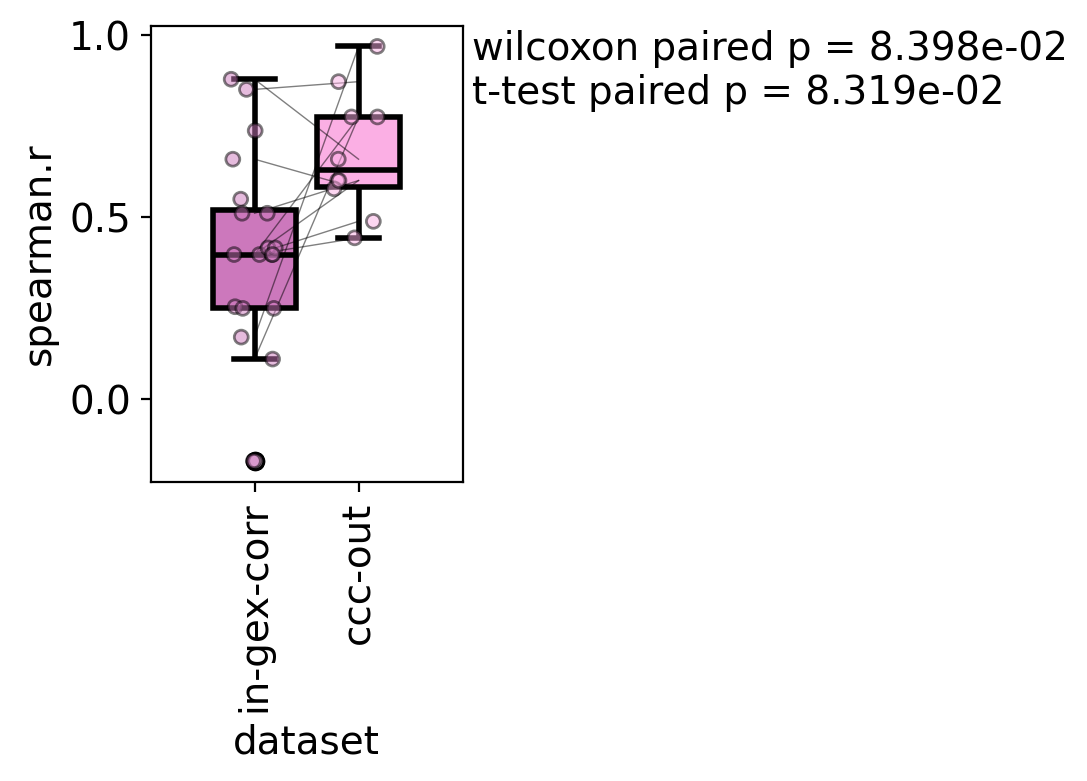

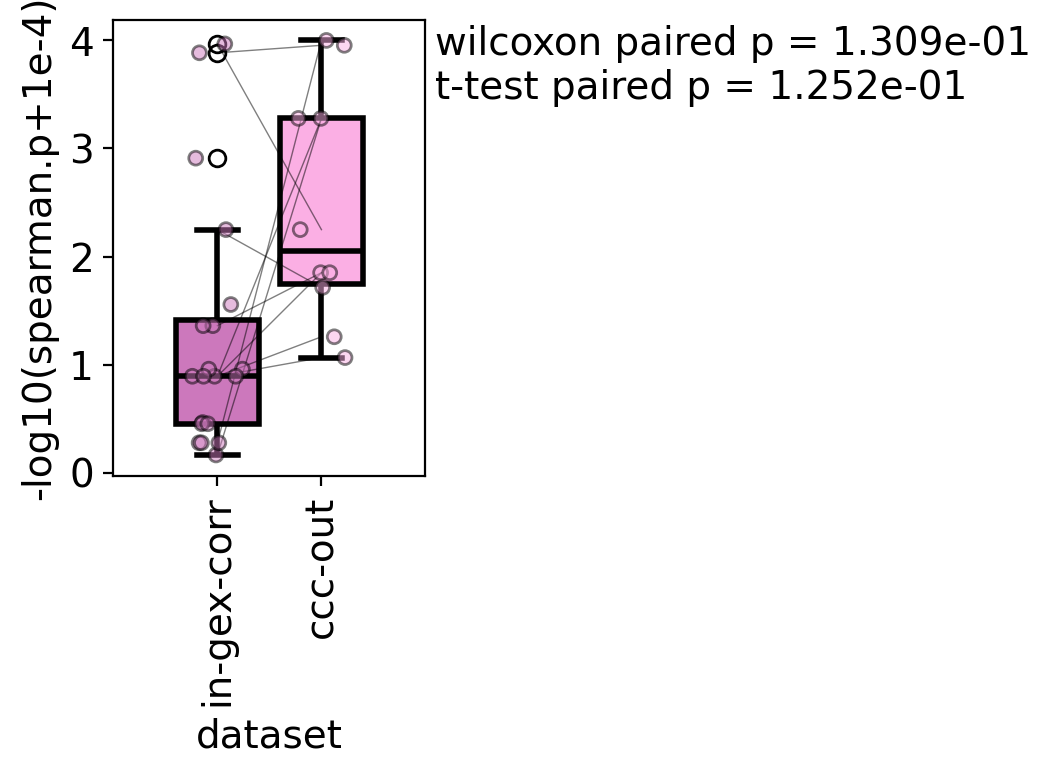

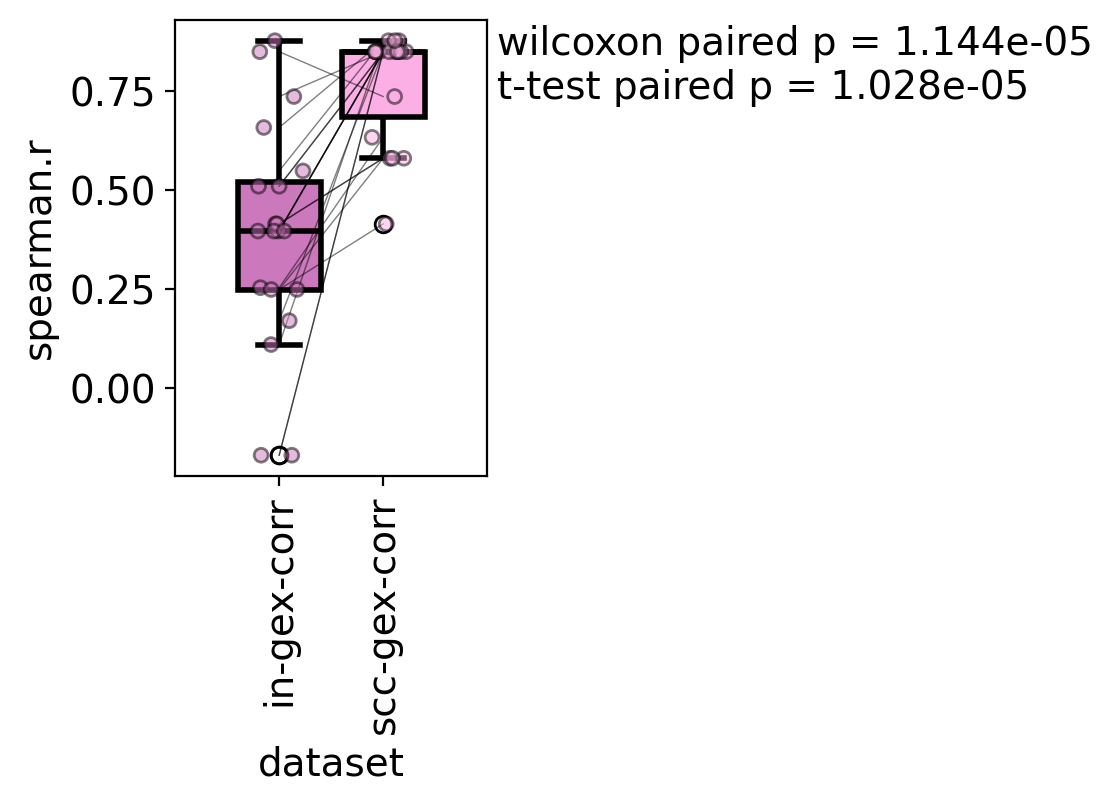

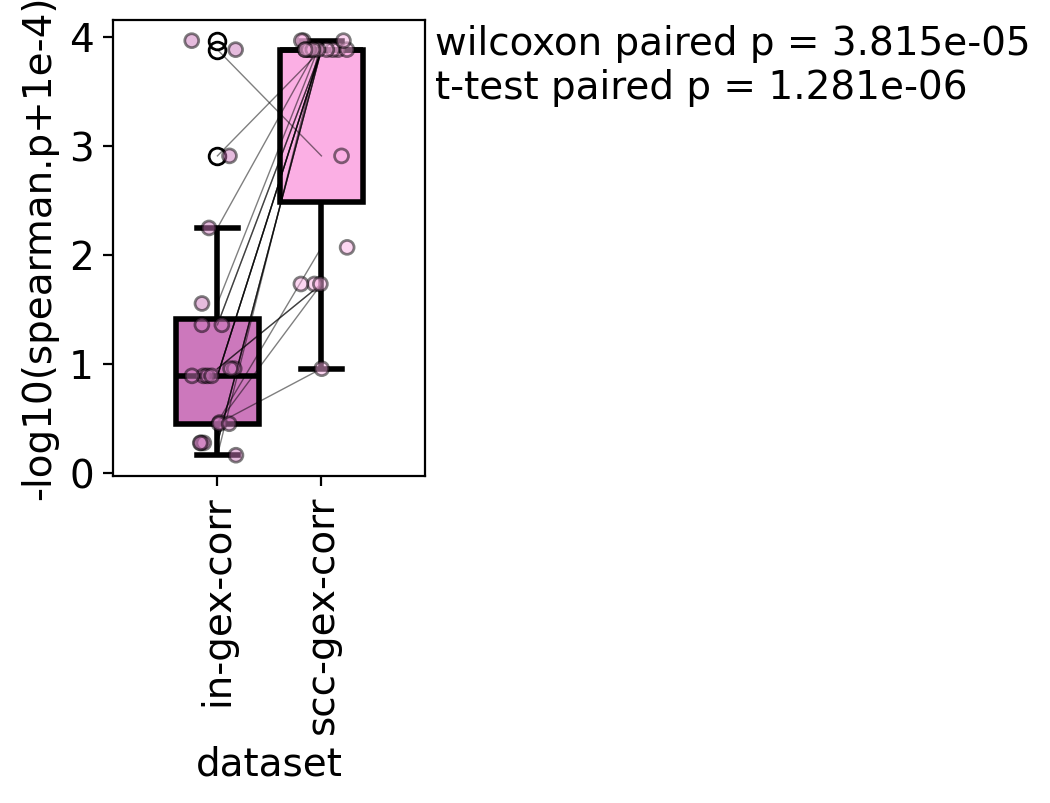

In [92]:
# melt the dataframe into a plottable function (complete this for intra for newly defined method)
data = results_intra.reset_index().melt(id_vars='index')
data['dataset'] = data['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_vs_')[0]).str.replace('_','-')
data['metric'] = data['index'].apply(lambda x: x.split('_')[0]+'.'+x.split('.')[-1])
data['nlog10p1en4_value'] = -np.log10(data['value'].astype(float)+1e-4)
# run through all of the plots
for metric, value, datasets in plotters:
    # plot key pairwise metrics
    fig, ax = plt.subplots(figsize=[2, 3])
    ax.grid(False)
    ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
                     saturation=1, ax=ax, order=datasets, linecolor='k', linewidth=2, palette=['#cc78bc','#fbafe4'])
    ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
                       ax=ax, order=datasets, edgecolor='k', linewidth=1, jitter=0.25, alpha=0.5, palette=['#cc78bc','#fbafe4'])
    ax.tick_params(axis='x', labelrotation=90)
    if value == 'nlog10p1en4_value':
        ax.set_ylabel(f'-log10({metric}+1e-4)')
    else:
        ax.set_ylabel(f'{metric}')
    # derive the values
    x1 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[0]), value].reset_index().iloc[:, 1]
    x2 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[1]), value].reset_index().iloc[:, 1]
    mask = (~x1.isna()) & (~x2.isna())
    x1, x2 = x1.loc[mask], x2.loc[mask]
    for idx in x1.index:
        ax.plot(datasets, [x1.loc[idx], x2.loc[idx]], color='k', lw=0.5, alpha=0.5, zorder=1)
    # derive the p-value
    pval1 = ss.wilcoxon(x1, x2)[1]
    pval2 = ss.ttest_rel(x1, x2)[1]
    text = 'wilcoxon paired p = %.3e' % pval1
    text += '\nt-test paired p = %.3e' % pval2
    ax.text(1.03, .99, text, va='top', ha='left', transform=ax.transAxes)
    ax.set_xlim(-1, 2)